# Cyclegan Testing

Based on **Transforming the World Into Paintings with CycleGAN** <br>
Implementing a CycleGAN In Keras and Tensorflow 2.0: [link](https://medium.com/analytics-vidhya/transforming-the-world-into-paintings-with-cyclegan-6748c0b85632)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# For the 'InstanceNormalization' layer
!pip install --upgrade tensorflow_addons
# For the dataset
!pip install --upgrade tensorflow_datasets

Requirement already up-to-date: tensorflow_addons in /usr/local/lib/python3.6/dist-packages (0.6.0)
Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.3.2)


In [0]:
import time
from tqdm import tqdm_notebook as tqdm 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import (Activation, Concatenate, Conv2D, BatchNormalization,
                                     Conv2DTranspose, Input, LeakyReLU, PReLU, Dropout)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

%matplotlib inline

In [4]:
cd gdrive/My\ Drive/Learning_Theory_Project/

/content/gdrive/My Drive/Learning_Theory_Project


In [0]:
# Load dataset: 
# Take a look here: https://www.tensorflow.org/datasets/catalog/cycle_gan

# Which Setting
#setting = 'mnist'
#setting = 'orange'
#setting = 'monet'
setting = 'blurring'

BUFFER_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

if setting == 'mnist': 
    data_mnist, metadata_mnist = tfds.load('mnist', with_info=True, as_supervised=True)
    data_svhn , metadata_svhn  = tfds.load('svhn_cropped', with_info=True, as_supervised=True)

    train_x, train_y, test_x, test_y = data_mnist['train'], data_svhn['train'], data_mnist['test'], data_svhn['test']

    scaling = 8

    img_rows, img_cols = int(256/scaling), int(256/scaling)
    img_rows, img_cols = int(256/scaling), int(256/scaling)
    channels = 3

    # Normalize images to [-1, 1] and reshape
    def preprocess_image_3(image, label):
        return tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (img_rows, img_cols, 3)), label

    def preprocess_image_1(image, label):
        return tf.tile(tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (img_rows, img_cols, 1)), tf.constant([1, 1, 3])), label

    # Map the normalization onto the dataset
    train_x = train_x.map(preprocess_image_1, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    train_y = train_y.map(preprocess_image_3, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_x = test_x.map(preprocess_image_1, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_y = test_y.map(preprocess_image_3, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

    x_batch_image, x_batch_label = next(iter(train_x.batch(32)))
    y_batch_image, y_batch_label = next(iter(train_y.batch(32)))

    fig, ax = plt.subplots(2,4)
    for i in range(4):
      ax[0][i].imshow(x_batch_image[i][:,:,0])
      ax[1][i].imshow(y_batch_image[i][:,:,0])
      ax[0][i].set_title(x_batch_label[i].numpy())
      ax[1][i].set_title(y_batch_label[i].numpy())
      ax[0][i].axis('off')
      ax[1][i].axis('off')

elif setting == 'monet':
    data, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)
    train_x, train_y, test_x, test_y = data['trainA'], data['trainB'], data['testA'], data['testB']
    
    scaling = 1
    
    img_rows, img_cols, channels = int(256/scaling), int(256/scaling), 3
    # Normalize images to [-1, 1] and reshape
    def preprocess_image(image, _):
        return tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1 , _

    # Map the normalization onto the dataset
    train_x = train_x.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    train_y = train_y.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_x = test_x.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_y = test_y.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

elif setting == 'orange': 
    data, metadata = tfds.load('cycle_gan/apple2orange', with_info=True, as_supervised=True)
    train_x, train_y, test_x, test_y = data['trainA'], data['trainB'], data['testA'], data['testB']
    
    scaling = 1
    
    img_rows, img_cols, channels = int(256/scaling), int(256/scaling), 3
    # Normalize images to [-1, 1] and reshape
    def preprocess_image(image, _):
        return tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1 , _

    # Map the normalization onto the dataset
    train_x = train_x.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    train_y = train_y.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_x = test_x.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_y = test_y.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

elif setting == 'blurring':
    data, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)
    train_x_orig, test_x_orig = data['trainB'], data['testB']
    
    scaling = 4
    
    img_rows, img_cols, channels = int(256/scaling), int(256/scaling), 3
    # Normalize images to [-1, 1] and reshape
    def preprocess_image(image, _):
        return tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1 , _

    blur = 5
    def preprocess_image_blur(image, _):
        return tf.cast(tf.image.resize(tf.image.resize(image, (int(img_rows/5), int(img_cols/5))), 
                                       (int(img_rows), int(img_cols))) , tf.float32) / 127.5 - 1 , _


    # Map the normalization onto the dataset
    train_x = train_x_orig.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    train_y = train_x_orig.map(preprocess_image_blur, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_x = test_x_orig.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)
    test_y = test_x_orig.map(preprocess_image_blur, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

else:
    raise ValueError('ERROR : SETTING should be mnist, monet OR orange.')


# Pre-loading old weights 
hot_start = False

In [0]:
# Settings
LAMBDA = 5
LAMBDA2 = 10

weight_initializer = RandomNormal(stddev=0.02)

optimizer = 'Adam'
#optimizer = 'RMSprop'

if optimizer == 'Adam':
  gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
  dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)
elif optimizer == 'Adam2':
  gen_g_optimizer = gen_f_optimizer = Adam(lr=0.001, beta_1=0.5)
  dis_x_optimizer = dis_y_optimizer = Adam(lr=0.001, beta_1=0.5)
elif optimizer == 'RMSprop':
  gen_g_optimizer = gen_f_optimizer = RMSprop(lr=0.0002, momentum=0.5 )
  dis_x_optimizer = dis_y_optimizer = RMSprop(lr=0.0002, momentum=0.5 )
else:
  raise ValueError('ERROR : Optimizer should be Adam or RMSprop!')

In [0]:
use_instancenorm = False

# "Ck denotes a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2
def Ck(input, k, use_instancenorm=True, start = False):
    block = Conv2D(k, (4, 4), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    if not start : 
      if use_instancenorm:
        block = InstanceNormalization(axis=-1)(block)
      else:
       block = BatchNormalization()(block)
    # Old code used LeakyRelu(0.2)
    block = LeakyReLU(0.2)(block)
    #block = PReLU()(block)

    return block

# C64, C128, C256, C512
def discriminator():
    dis_input = Input(shape=(img_rows, img_cols, channels))

    d = Ck(dis_input, 64, use_instancenorm, start = True)
    d = Ck(d, 128, use_instancenorm)
    d = Ck(d, 256, use_instancenorm)
    d = Ck(d, 512, use_instancenorm)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=weight_initializer)(d)

    return Model(dis_input, d)

In [0]:
# "dk denotes a 3×3 Convolution-InstanceNorm-ReLU with k filters and stride 2"
def dk(k, use_instancenorm=True, start = False):
    block = Sequential()
    block.add(Conv2D(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    if not start:
        if use_instancenorm:
            block.add(InstanceNormalization(axis=-1))
        else:
            block.add(BatchNormalization())
    # changed relu to lrelu
    block.add(Activation(tf.nn.relu))

    return block

# "uk denotes a 3×3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride ½"
def uk(k, use_instancenorm=True, start = False, apply_dropout=False):
    block = Sequential()
    block.add(Conv2DTranspose(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer))
    if not start:
        if use_instancenorm:
            block.add(InstanceNormalization(axis=-1))
        else:
            block.add(BatchNormalization())
        if apply_dropout:
            block.add(Dropout(0.5))
    # changed relu to lrelu
    block.add(Activation(tf.nn.relu))

    return block

def generator():
    gen_input = Input(shape=(img_rows, img_cols, channels))
    
    # Layers for the encoder part of the model
    encoder_layers = [
        dk(64, use_instancenorm, start = True),
        dk(128, use_instancenorm),
        dk(256, use_instancenorm),
        dk(512, use_instancenorm),
        #dk(512, use_instancenorm),
        #dk(512, use_instancenorm),
        dk(512, use_instancenorm),
        dk(512, use_instancenorm)
    ]

    # Layers for the decoder part of the model
    decoder_layers = [
        uk(512, use_instancenorm, apply_dropout=True),
        uk(512, use_instancenorm, apply_dropout=True),
        #uk(512, use_instancenorm, apply_dropout=True),
        #uk(512, use_instancenorm, apply_dropout=True),
        uk(256, use_instancenorm),
        uk(128, use_instancenorm),
        uk(64, use_instancenorm)
    ]

    gen = gen_input

    # Add all the encoder layers, and keep track of them for skip connections
    skips = []
    for layer in encoder_layers:
        gen = layer(gen)
        skips.append(gen)
    
    skips = skips[::-1][1:] # Reverse for looping and get rid of the layer that directly connects to decoder

    # Add all the decoder layers and skip connections
    for skip_layer, layer in zip(skips, decoder_layers):
        gen = layer(gen)
        gen = Concatenate()([gen, skip_layer])
    
    # Final layer
    gen = Conv2DTranspose(channels, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer, activation='tanh')(gen)
    
    # Compose model
    return Model(gen_input, gen)

In [0]:
# Define the models
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

In [0]:
 # Losses
loss = BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    return ( loss(tf.ones_like(real) + tf.random.normal(real.shape,
                                                        mean=0.0, 
                                                        stddev=.1, 
                                                        dtype=tf.dtypes.float32) , real) + \
            loss(tf.zeros_like(generated) + tf.random.normal(generated.shape,mean=0.0, 
                                                             stddev=.1,
                                                             dtype=tf.dtypes.float32), generated) )

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity) + tf.random.normal(validity.shape,
                                                          mean=0.0, 
                                                          stddev=.1, 
                                                          dtype=tf.dtypes.float32) , validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

# CHANGE : FEATURIZER
featurizer = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in featurizer.layers:
    layer.trainable = False

# Measures similarity of two images.  Used for cycle and identity loss
def pixel_image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

# Measures similarity of two images.  Used for cycle and identity loss
def featurizer_similarity(image1, image2):
    image1_rep = featurizer(image1)
    image2_rep = featurizer(image2)
    return pixel_image_similarity(image1_rep, image2_rep)

pixel_weight = tf.Variable(0.2)
def image_similarity(image1, image2):
    return pixel_weight * pixel_image_similarity(image1, image2)\
           + (1 - pixel_weight) * featurizer_similarity(image1, image2)

In [0]:
upscale_discriminator = 0.5

In [0]:
@tf.function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Discriminator upscaling
        
        # Setup Dy loss
        fake_y = generator_g(real_x, training=True)
        gen_g_validity = discriminator_y(fake_y, training=True)*upscale_discriminator
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        # Setup Dx loss
        fake_x = generator_f(real_y, training=True)
        gen_f_validity = discriminator_x(fake_x, training=True)*upscale_discriminator
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

        # Setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity)
        gen_f_adv_loss = gen_loss(gen_f_validity)

        # Setup cycle losses
        cyc_x = generator_f(fake_y, training=True)
        cyc_x_loss = image_similarity(real_x, cyc_x)

        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y)

        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x)

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * LAMBDA2 * 0.5 
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * LAMBDA2 * 0.5 

        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

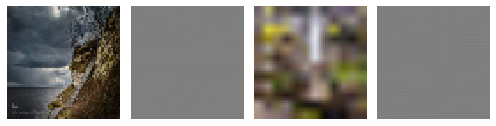

In [23]:
def generate_images(size=1):
    # Sample images
    x, _ = next(iter(test_x.shuffle(1000)))
    y, _ = next(iter(test_y.shuffle(1000)))

    x = x.numpy().reshape((1, img_rows, img_cols, channels))
    y = y.numpy().reshape((1, img_rows, img_cols, channels))
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f.predict(y.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(7*size, 15*size))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for _ in range(1):
    generate_images()

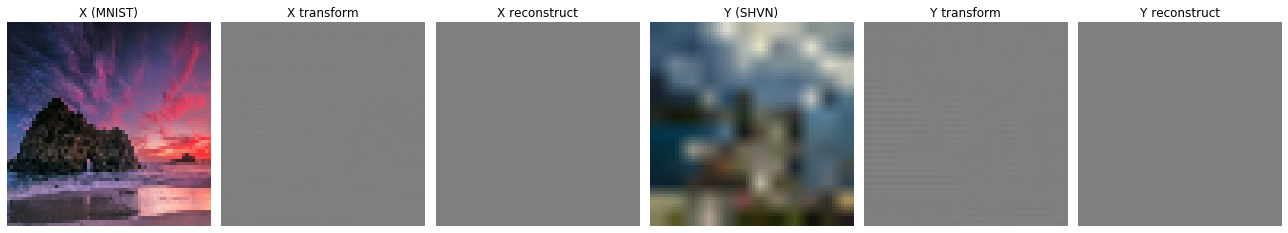

In [24]:
def generate_images2(size=1, name = None):
    # Sample images
    x, _ = next(iter(test_x.shuffle(1000)))
    y, _ = next(iter(test_y.shuffle(1000)))

    x = x.numpy().reshape((1, img_rows, img_cols, channels))
    y = y.numpy().reshape((1, img_rows, img_cols, channels))

    # Get predictions for those images
    x_transform = generator_g.predict(x)
    y_transform = generator_f.predict(y)

    # Get reconstruction for those images
    x_reconstruct = generator_f.predict(x_transform.reshape((1, img_rows, img_cols, channels)))
    y_reconstruct = generator_g.predict(y_transform.reshape((1, img_rows, img_cols, channels)))

    plt.figure(figsize=(9*size, 20*size))

    images = [x[0], x_transform[0], x_reconstruct[0],  y[0], y_transform[0], y_reconstruct[0]]

    if setting == 'monet': 
      title = ['X (monet)', 'X transform', 'X reconstruct', 'Y (real)', 'Y transform', 'Y reconstruct']
    elif setting == 'apple': 
      title = ['X (apple)', 'X transform', 'X reconstruct', 'Y (orange)', 'Y transform', 'Y reconstruct']
    else: 
      title = ['X (MNIST)', 'X transform', 'X reconstruct', 'Y (SHVN)', 'Y transform', 'Y reconstruct']

    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
        plt.title(title[i])
    plt.tight_layout()
    if name != None: plt.savefig('results_' + setting + '/' + name, bbox_inches = 'tight')
    plt.show()

if hot_start: 
  generator_g.load_weights('models_' + setting + '/'   + 'generator_g.h5')
  generator_f.load_weights('models_' + setting + '/'   + 'generator_f.h5')
  discriminator_x.load_weights('models_' + setting + '/'   + 'discriminator_x.h5')
  discriminator_y.load_weights('models_' + setting + '/'   + 'discriminator_y.h5')

for _ in range(1):
    generate_images2(2)

In [25]:
x_length = len([x for x in iter(train_x)])
y_length = len([y for y in iter(train_y)])
print('train_x contains {} images'.format(x_length))
print('train_y contains {} images'.format(y_length))

train_x contains 6287 images
train_y contains 6287 images


In [0]:
epochs = 40
generate_images_epoch = 1
batch_size = 1
epoch_images = int( int( min(x_length, y_length) ) / batch_size)
#epoch_images = 200

# Timer
start = time.time()

# Manually loop through epochs
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    #LAMBDA2 = 2*LAMBDA2 / (2+epoch)
    #upscale_discriminator = upscale_discriminator*1.1

    # Each batch
    for k, ((real_x, x_label), (real_y, y_label)) in tqdm(enumerate(tf.data.Dataset.zip((train_x.batch(batch_size), train_y.batch(batch_size)))), total = epoch_images):
      
        if k == epoch_images: 
          break
        
        # Train step
        step(tf.reshape(real_x, (batch_size  , img_rows, img_cols, channels)), tf.reshape(real_y, (batch_size, img_rows, img_cols, channels)))
    
    # View progress
    if epoch % generate_images_epoch == 0: 
      print('Every {} epoch generating images:'.format(generate_images_epoch))
      name = 'cycle_epoch_{}_{}'.format(epoch,'training')
      generate_images2(size=1.5, name = name)
    
    generator_g.save('models_' + setting + '/'   + 'generator_g.h5')
    generator_f.save('models_' + setting + '/'   + 'generator_f.h5')
    discriminator_x.save('models_' + setting + '/'   + 'discriminator_x.h5')
    discriminator_y.save('models_' + setting + '/'   + 'discriminator_y.h5')

    # Time taken
    dif_time = time.time() - start
    print('Time taken: {}m {}s'.format(round(dif_time // 60), round(dif_time  % 60)))

    generator_g.save('models_' + setting + '/'   + 'generator_g_end.h5')
    generator_f.save('models_' + setting + '/'   + 'generator_f_end.h5')
    discriminator_x.save('models_' + setting + '/'   + 'discriminator_x_end.h5')
    discriminator_y.save('models_' + setting + '/'   + 'discriminator_y_end.h5')

print('\n##################\n#### FINISHED ####\n##################\n\nTotal Time taken: {}m {}s'.format(round(dif_time // 60), round(dif_time  % 60)))

Epoch: 0


In [0]:
for i in range(5):
    name = 'end_cycle_epoch_{}_{}'.format(epoch,i)
    generate_images2(size=1.5, name = name)

In [0]:
for _ in range(5):
    generate_images(size=1.6)

In [0]:
print('End')

In [0]:
generator_g.save('models/' + setting + 'generator_g.h5')
generator_f.save('models/' + setting + 'generator_f.h5')
discriminator_x.save('models/' + setting + 'discriminator_x.h5')
discriminator_y.save('models/' + setting + 'discriminator_y.h5')